$\textbf{Every-visit Monte Carlo control tailored for the reset application}$

The pseudo-code for the every-visit Monte Carlo control tailored for the reset application can be found in Algorithm 2.

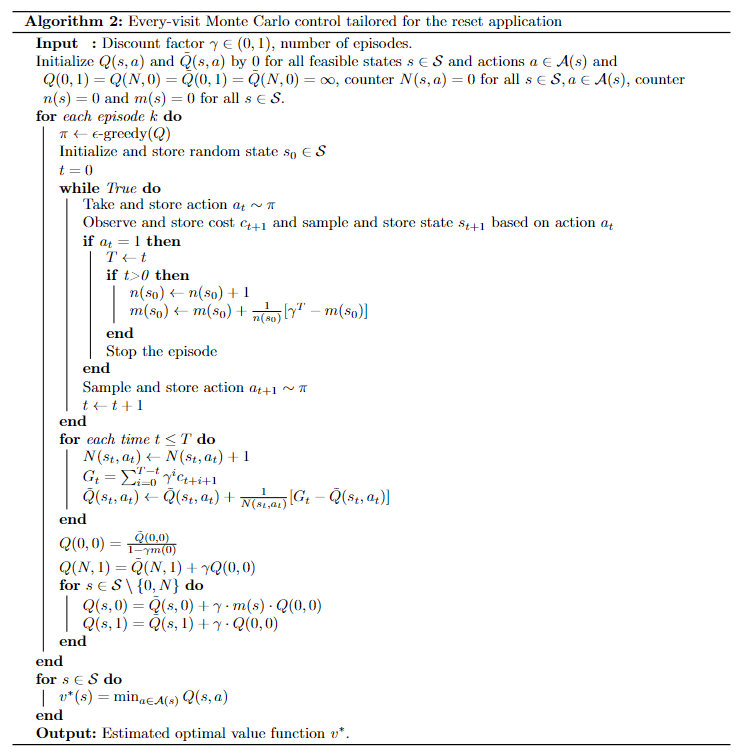

The implementation of this algorithm can be found in the code below.

In [1]:

import numpy as np
import time
import matplotlib.pyplot as plt


def Every_Visit_Monte_Carlo(gamma, epsilon,P,C_0,C_1, nrepisodes):
     # in case we want to use one of the three epsilon depending
     # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
     # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
     # epsilon_type = 4: epsilon = 1/(episode nr)
     epsilon_type = epsilon
     
     # size of the state space-1
     N=np.size(P,1)-1
     
     # state space S
     S=np.arange(N+1)
     
     # Initializing Q-values by 0, here the rows correspond to the action and columns to the state
     # i.e., Q is of the form Q[s,a]
     Q=np.zeros([N+1,2])
     
     # setting the Q value for "illegal" actions to infinity
     Q[0,1]=float("inf")
     Q[N,0]=float("inf")
     
     # Q value of the reset application
     Q_reset = Q.copy()

     
     # n_it[s,a] denotes the number of times (s,a) is visited
     n_it = np.zeros([N+1,2])
     
     # n(s): the number of times the episode started in state s
     n_s0 = np.zeros(N+1)
     
     # m(s): 
     m = np.zeros(N+1)
     
     
     # array containing the T's for each episode
     T_it = []
     
     # Q[s,a,episode number]: array to keep track of the Q-values per episode
     Q_it=np.zeros([N+1,2,nrepisodes])
     
     # Q_reset[s,a,episode number]: array to keep track of the Q-values for the reset application per episode
     Q_reset_it=np.zeros([N+1,2,nrepisodes])
     
     # keep track of the the optimal policy according to that episode
     policy_reset_it=np.zeros([N+1,nrepisodes])
     
     # loop for each episode
     for e in range(1,nrepisodes+1):
         # initializing an array containing all states S_{t},S_{t+1},...,S_{t+T}
         states = []
         
         # initializing an array containing all actions A_0,A_1,...,A_T
         actions = []
         
         # initializing an array containing all rewards R_0,R_1,...,R_T
         rewards = []
         
         
         # randomly selecting and storing initial state
         states.append(np.random.randint(0, N+1))
         
         # iteration within the episode
         t = 0
    
         ## select and store an action a_0
         ## epsilon-greedy policy:
         p=np.random.random() # sampling a p in [0,1)
         
         if epsilon_type==2:
         # epsilon = 1/min(episode nr, minimum nr of visits to state s)
             epsilon=1/min(e,max(1,min(n_it[states[0],:])))
         elif epsilon_type==3:
         # epsilon = 1/(minimum nr of visits to state s)
             epsilon=1/max(1,min(n_it[states[0],:]))
         elif epsilon_type==4:
         # epsilon = 1/episode nr
             epsilon = 1/e
         
         # with probability eps: random policy
         if p<epsilon: 
             actions.append(np.random.randint(0, 2)) 
         # with probability 1-eps: greedy policy
         else: 
             # choosing the action that minimizes the Q-value for state s_0,
             # here ties are broken arbitrarily:
             actions.append(np.random.choice(np.flatnonzero(Q_reset[states[0],:] == Q_reset[states[0],:].min())))
         
         
         # making sure the chosen action is allowed for the state
         if states[0]==0:
             actions[0]=0 
         elif states[0]==N:
             actions[0]=1
             
         while True:
             # taking action A_t 
             # observing and storing the next reward as R_{t+1}
             # and sampling the next state S_{t+1} according to P   
             if actions[t]==1:
                 # append the cost of the state-action pair to the array
                 rewards.append(C_1[states[t]]) 
                 
                 # set the number of time-steps T equal to the t
                 T=t
                 
                 # we check if t>0 to make sure that A_0 = 0
                 if t>0:
                     # the number of times we started in s_0 with a_0=0
                     n_s0[states[0]]+=1
                     
                     # an array with all stopping times T
                     T_it.append(T)
                     
                     # compute m(s_0) using the incremental mean
                     m[states[0]]+=(1/n_s0[states[0]])*(gamma**T-m[states[0]])  
                 break
                 
             elif actions[t]==0:
                 # select and store the next action according to P
                 states.append(np.random.choice(S,p=P[states[t],:]))
                 # select and store the cost for action 0 in the current state
                 rewards.append(C_0[states[t]])
               

             
             ## select and store an action A_{t+1} ~ pi(.|S_{t+1}) = eps-greedy policy
             ## epsilon-greedy policy:
             p=np.random.random() # sampling a p in [0,1)
             
             if epsilon_type==2:
             # epsilon = 1/min(episode nr, minimum nr of visits to state s)
                 epsilon=1/min(e,max(1,min(n_it[states[t+1],:])))
             elif epsilon_type==3:
             # epsilon = 1/(minimum nr of visits to state s)
                 epsilon=1/max(1,min(n_it[states[t+1],:]))
             elif epsilon_type==4:
             # epsilon = 1/episode nr
                 epsilon = 1/e
             
             
             # with probability eps: random policy
             if p<epsilon: 
                 actions.append(np.random.randint(0, 2)) 
             # with probability 1-eps: greedy policy
             else: 
                 # choosing the action that minimizes the Q-value for state s_{t+1},
                 # here ties are broken arbitrarily:
                 actions.append(np.random.choice(np.flatnonzero(Q_reset[states[t+1],:] == Q_reset[states[t+1],:].min())))


             # making sure the randomly chosen action is allowed for the state
             if states[t+1]==0:
                 actions[t+1]=0 
             elif states[t+1]==N:
                 actions[t+1]=1
             
             t+=1
                
         
         
         
         for t in range(0,T+1):
             # G: array containing the return at times t=0,...T
             G = np.zeros(T+1)
             
             # incrementing the nr of visits to (s,a) by 1    
             n_it[states[t],actions[t]]+=1
            
             # computing the return G_t
             G[t] = np.sum([(gamma**i)*rewards[t+i] for i in range(0,T-t+1)])
            
             # updating the Q-values
             Q[states[t],actions[t]]+=(1/n_it[states[t],actions[t]])*(G[t]-Q[states[t],actions[t]])
            
             # keeping track of the (updated) Q-value for the current episode
             Q_it[states[t],actions[t],e-1]=Q[states[t],actions[t]]
        
         # computing the Q-values for the reset application
         Q_reset[0,0] = Q[0,0]/(1-gamma*m[0])
         Q_reset[1:N,0] = Q[1:N,0] + gamma*Q_reset[0,0]*m[1:N]
         Q_reset[1:,1] = Q[1:,1] + gamma*Q_reset[0,0]
         
         # keeping track of the (updated) Q-values and policy for the reset application for the current episode
         Q_reset_it[:,0,e-1] = Q_reset[:,0]
         Q_reset_it[:,1,e-1] = Q_reset[:,1]
         policy_reset_it[:,e-1] = np.argmin(Q_reset, axis=1)
     
     # computing the Q-values for the reset application
     Q_reset[0,0] = Q[0,0]/(1-gamma*m[0])
     Q_reset[1:N,0] = Q[1:N,0] + gamma*Q_reset[0,0]*m[1:N]
     Q_reset[1:,1] = Q[1:,1] + gamma*Q_reset[0,0]
     
     # the optimal policy and optimal value 
     policy_reset_opt = np.argmin(Q_reset, axis=1)
     v_reset_opt = np.min(Q_reset, axis=1) 
         
     return Q, Q_it, n_it, T_it, Q_reset, policy_reset_opt, Q_reset_it, v_reset_opt, policy_reset_it



Initializing the algorithm's parameters:

In [6]:
# discount factor
gamma=0.3

# epsilon in epsilon-greedy:
     # in case we want to use one of the three epsilon depending
     # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
     # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
     # epsilon_type = 4: epsilon = 1/(episode nr)
        
epsilon=3

# nr of episodes
nrepisodes = 2000

# number of states - 1
N=3


Initializing the probability transition matrix (choose one of the three): 

In [ ]:
# P_A
P = np.diag(np.ones(N),1)
P[N,0]=1


In [3]:
# P_B
P = np.diag(1/2*np.ones(N),1)+np.diag(1/2*np.ones(N),-1)
P[-1,-2]=1
P[0,1]=1


In [ ]:
# P_C
P = 1/4*np.ones([N+1,N+1])


Initializing the cost realization (choose one of the three):

In [4]:
# Realization 1

# Cost for action = 0
C_0=np.zeros(N+1)

# Cost for action = 1
C_1=np.arange(N+1,dtype=float)
C_1[N]=2*N


In [ ]:
# Realization 2

# Cost for action = 0
C_0=np.arange(N+1,dtype=float)+1 

# Cost for action = 1
K=2
C_1=K*C_0


In [ ]:
# Realization 3

# Cost for action = 0
C_0=1/np.arange(N+1,0,-1,dtype=float)

# Cost for action = 1
C_1=10**np.arange(N+1,dtype=float)


$\textit{Example}:$ cost realization 1 with transition matrix $\mathcal{P}_B$ for $\gamma=0.3$ and $N=3$.

In [7]:
Q, Q_it, n_it, T_it, Q_reset, policy_reset_opt, Q_reset_it, v_reset_opt,  policy_reset_it = Every_Visit_Monte_Carlo(gamma, epsilon,P,C_0,C_1, nrepisodes)


print("Q-value: \n",Q_reset)
print("Optimal policy: \n",policy_reset_opt)
print("Optimal value: \n",v_reset_opt)

Q-value: 
 [[0.04974551        inf]
 [0.15185081 1.01492365]
 [0.93637594 2.01492365]
 [       inf 6.01492365]]
Optimal policy: 
 [0 0 0 1]
Optimal value: 
 [0.04974551 0.15185081 0.93637594 6.01492365]
